# Нейронные сети
__Суммарное количество баллов: 10__

Для начала вам предстоит реализовать свой собственный backpropagation и протестировать его на реальных данных, а затем научиться обучать нейронные сети при помощи библиотеки `PyTorch` и использовать это умение для классификации классического набора данных CIFAR10.

Обратите внимание, что использование PyTorch во всех заданиях кроме последнего запрещено. Автоматической проверки на его использование не будет, однако все посылки будут проверены вручную. 

In [1]:
import numpy as np
import copy
from sklearn.datasets import make_blobs, make_moons
from typing import List, NoReturn

### Задание 1 (3 балла)
Нейронные сети состоят из слоев, поэтому для начала понадобится реализовать их. Пока нам понадобятся только три:

`Linear` - полносвязный слой, в котором `y = Wx + b`, где `y` - выход, `x` - вход, `W` - матрица весов, а `b` - смещение. 

`ReLU` - слой, соответствующий функции активации `y = max(0, x)`.


#### Методы
`forward(X)` - возвращает предсказанные для `X`. `X` может быть как вектором, так и батчем

`backward(d)` - считает градиент при помощи обратного распространения ошибки. Возвращает новое значение `d`

`update(alpha)` - обновляет веса (если необходимо) с заданой скоростью обучения

#### Оценка
Валидируется корректность работы каждого модуля отдельно. Ожидается, что выходы каждого модуля будут незначительно отличаться от ожидаемых выходов, а подсчет градиента и градиентный спуск будут работать корректно.

In [2]:
from task import ReLU, Linear

### Задание 2 (2 балла)
Теперь сделаем саму нейронную сеть.

#### Методы
`fit(X, y)` - обучает нейронную сеть заданное число эпох. В каждой эпохе необходимо использовать [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) для обучения, а так же производить обновления не по одному элементу, а используя батчи.

`predict_proba(X)` - предсказывает вероятности классов для элементов `X`

#### Параметры конструктора
`modules` - список, состоящий из ранее реализованных модулей и описывающий слои нейронной сети. В конец необходимо добавить `Softmax`

`epochs` - количество эпох обучения

`alpha` - скорость обучения

#### Оценка
Оценка производится на заданных ботом гиперпараметрах и архитектурах. Ожидается, что при подобранных заранее гиперпараметрах решение будет демонстрировать приемлемую точность.

Всего 20 тестов по 500 точек в обучающей выборке и по 100 точек в тестовой выборке c 20 эпохами обучения и 10 тестов по 1000 точек в обучающей выборке и 200 точек в тестовой выборке с 40 эпохами обучения. Количество признаков варьируется от 2 до 8. Количество классов не более 8 и не менее 2.

In [3]:
from task import MLPClassifier

In [4]:
p = MLPClassifier([
    Linear(4, 8),
    ReLU(),
    Linear(8, 8),
    ReLU(),
    Linear(8, 2)
])

X = np.random.randn(50, 4)
y = [(0 if x[0] > x[2]**2 or x[3]**3 > 0.5 else 1) for x in X]
p.fit(X, y)

### Задание 3 (2 балла)
Протестируем наше решение на синтетических данных. Необходимо подобрать гиперпараметры, при которых качество полученных классификаторов будет достаточным.

Первый датасет - датасет moons. В каждом тесте у данных всего два признака, классов также два.

Второй датасет - датасет blobs. В каждом тесте у данных по два признака, классов три.


Обратите внимание, что датасеты могут отличаться от приведенных ниже по количеству точек, уровню шума и положению центроидов. Количество классов и признаков остается неизменным.

Обратите внимание, что классификатор будет обучаться ботом под каждый датасет отдельно. Обучать самостоятельно в файле `task.py` классификатор не нужно.

Количество датасетов каждого типа равно 5. Количество точек в обучающей выборке не менее 1000, количество точек в тестовой выборке не менее 200.

#### Оценка
Средняя точность на датасетах moons больше 0.85 - +1 балл

Средняя точность на датасетах blobs больше 0.85 - +1 балл

In [5]:
from task import classifier_moons, classifier_blobs

In [6]:
X, y = make_moons(400, noise=0.075)
X_test, y_test = make_moons(400, noise=0.075)
classifier_moons.fit(X, y)
print("Accuracy", np.mean(classifier_moons.predict(X_test) == y_test))

Accuracy 1.0


In [7]:
X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
X_test, y_test = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
classifier_blobs.fit(X, y)
print("Accuracy", np.mean(classifier_blobs.predict(X_test) == y_test))

Accuracy 0.9525


## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/) или обучать сеть на CPU.

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)
t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())

mps
Files already downloaded and verified
Files already downloaded and verified


### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `TorchModel` и функцию `calculate_loss`.

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [10]:
from task import TorchModel, calculate_loss

Теперь обучим нашу модель. Для этого используем ранее созданные batch loader'ы.

In [11]:
def train(model, epochs=100):

    # optimizer
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []

    # train
    for i in range(epochs):
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):

            # send to device
            X = X.to(device)
            y = y.to(device)

            # calculate loss
            loss = calculate_loss(X, y, model)

            # zero_grad
            optimizer.zero_grad()

            # backward
            loss.backward()

            # step
            optimizer.step()

            # calculate loss
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)

        # test
        loss_mean = 0 
        elements = 0

        for X, y in iter(test_loader):

            # to device
            X = X.to(device)
            y = y.to(device)

            # calculate loss
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [12]:
# import importlib
# importlib.reload(module)

In [13]:

model = TorchModel().to(device)
train_l, test_l = train(model)
# model = ''
# train_l, test_l = '', ''

Epoch 0 | Train loss 2.1564478441619874 | Test loss 1.96842543258667
Epoch 1 | Train loss 1.8867629085922242 | Test loss 1.7966135969161987
Epoch 2 | Train loss 1.7399836666870117 | Test loss 1.665975256919861
Epoch 3 | Train loss 1.631735888900757 | Test loss 1.5932248752593994
Epoch 4 | Train loss 1.5806090237045287 | Test loss 1.5701950075149536


KeyboardInterrupt: 

Построим график функции потерь

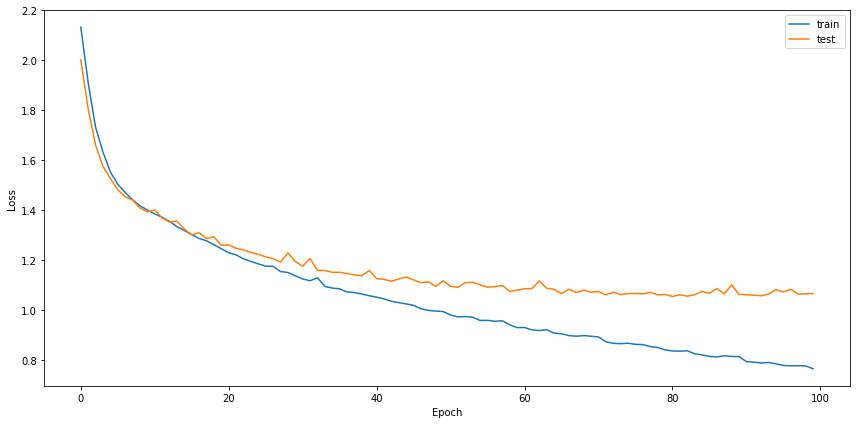

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [37]:
true_positive = np.zeros(10)
true_negative = np.zeros(10)
false_positive = np.zeros(10)
false_negative = np.zeros(10)

accuracy = 0
ctn = 0

for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)

print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))
print("F1", true_positive / (true_positive + 0.5 * (false_positive + false_negative)))

Overall accuracy 0.6369
Precision [0.70348259 0.73091977 0.54295154 0.44978166 0.57835052 0.54310345
 0.68500444 0.73310424 0.66912972 0.71428571]
Recall [0.707 0.747 0.493 0.412 0.561 0.567 0.772 0.64  0.815 0.655]
Mean Precision 0.6350113627165346
Mean Recall 0.6369
F1 [0.70523691 0.7388724  0.51677149 0.43006263 0.56954315 0.55479452
 0.72590503 0.68339562 0.7348963  0.68335942]
